# Ikeda eddy regression

# Purpose
It has proven to be very hard to reproduce the results from <cite data-cite="7505983/4AFVVGNT"></cite>. This notebook will develop a regression to correct the implementation.

# Methodology
Regression will be made to the $C_r$ coefficient.

# Setup

In [1]:
# %load imports.py
"""
These is the standard setup for the notebooks.
"""

%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../../")

import pandas as pd
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.set_option("display.max_columns", None)
import numpy as np
import os
import matplotlib.pyplot as plt
from collections import OrderedDict
import copy
from sklearn.pipeline import Pipeline
from rolldecayestimators.transformers import CutTransformer, LowpassFilterDerivatorTransformer, ScaleFactorTransformer, OffsetTransformer
from rolldecayestimators.direct_estimator_cubic import EstimatorQuadraticB, EstimatorCubic
from rolldecayestimators.ikeda_estimator import IkedaQuadraticEstimator
import src.equations as equations
import rolldecayestimators.lambdas as lambdas
from rolldecayestimators.substitute_dynamic_symbols import lambdify
import rolldecayestimators.symbols as symbols
import sympy as sp

from sympy.physics.vector.printing import vpprint, vlatex
from IPython.display import display, Math, Latex

from sklearn.metrics import r2_score
import shipflowmotionshelpers.shipflowmotionshelpers as helpers
import src.visualization.visualize as visualize
import scipy
from copy import deepcopy
import joblib

Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 462 ('figure.figsize   : 5, 3   ## figure size in inches')
Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 463 ('figure.dpi       : 100        ## figure dots per inch')


In [2]:
import rolldecayestimators.equations_ikeda_naked as equations_ikeda_naked
import rolldecayestimators.ikeda_naked as ikeda_naked
from src.helpers import calculate_lewis,calculate_B_star_hat,estimate_bilge_radius, estimate_sigma
import seaborn as sns
import joblib
from rolldecayestimators.substitute_dynamic_symbols import run

In [3]:
ikeda_sections_path = r'../../data/processed/Ikeda two-dimensional cylinders/ikeda_sections.csv'
df_ikeda_sections = pd.read_csv(ikeda_sections_path, index_col=0)

df_ikeda_sections.rename(columns= {
    'B_e_star_hat':'B_E_star_hat',
    'd':'T',
    'w_hat':'omega_hat', 
    'L':'L_pp', 
    'B':'beam', 
    'volume':'Disp', 
}, inplace=True)

df_ikeda_sections.rename(columns={
    'T':'T_s',
}, inplace=True)
df_ikeda_sections.head()

,phi_a,B_star_hat,omega_hat,model,B_W+B_F,B_E_star_hat,L_pp,beam,T_s,Disp,H0,sigma,OG/d,R,B_E0_HAT,C_r,a_1,a_3
0,0.23,0.041169,0.751,A,0.003636,0.037534,0.8,0.28,0.112,0.02509,1.25,1.000,0.0,0.00,0.031860,6.791066,0.095721,-0.138514
1,0.24,0.029803,0.507,A,0.001391,0.028413,0.8,0.28,0.112,0.02509,1.25,1.000,0.0,0.00,0.024117,7.297515,0.095721,-0.138514
2,0.30,0.023966,0.751,B,0.003265,0.020700,0.8,0.28,0.112,0.02501,1.25,0.997,0.0,0.01,0.017571,2.862276,0.095950,-0.136454
3,0.30,0.014438,0.536,B,0.001111,0.013328,0.8,0.28,0.112,0.02501,1.25,0.997,0.0,0.01,0.011313,2.582057,0.095950,-0.136454
4,0.27,0.008265,0.751,C,0.002115,0.006151,0.8,0.28,0.112,0.02495,1.25,0.995,0.0,0.02,0.005221,0.942686,0.096102,-0.135084


In [4]:
solution = sp.solve(equations_ikeda_naked.eq_B_E_star_hat, symbols.B_E0_hat)[0]
lambda_B0_hat = lambdify(solution)

equations_ikeda_naked.eq_B_E_star_hat

Eq(B_E0_HAT, 8*B_E_star_hat/(3*pi))

In [5]:
df_ikeda_sections['B_E0_HAT'] = run(lambda_B0_hat, df_ikeda_sections)

In [6]:
solution = sp.solve(equations_ikeda_naked.eq_B_E0_hat, symbols.C_r)[0]
lambda_C_r = lambdify(solution)
eq_C_r = sp.Eq(symbols.C_r,solution)
eq_C_r

Eq(C_r, 3*pi*B_E0_HAT*Disp*beam**2/(4*L_pp*T_s**4*omega_hat*phi_a))

In [7]:
df_input = df_ikeda_sections.copy()
df_ikeda_sections['C_r'] = run(lambda_C_r,df_ikeda_sections)

## Calculate Lewis coefficients

In [8]:
df_ = df_ikeda_sections.copy()
df_['B'] = df_['beam']
df_['d'] = df_['T_s']
#df_['d'] = df_['T']

a, a_1, a_3, sigma_s, H = calculate_lewis(df_)
df_ikeda_sections['a_1'] = a_1
df_ikeda_sections['a_3'] = a_3
df_ikeda_sections['H0'] = H

In [9]:
#df_ikeda_sections.to_csv(ikeda_sections_path)

## Estimate bilge radius

In [10]:
df_ = df_ikeda_sections.copy()
df_['B'] = df_['beam']
df_['d'] = df_['T_s']
#df_['d'] = df_['T']
mask = df_ikeda_sections['R'].isnull()
df_['B'] = df_['beam']
df_ikeda_sections.loc[mask,'R'] = estimate_bilge_radius(**df_.loc[mask])

In [11]:
df_ikeda_sections.to_csv('../../data/processed/ikeda_sections_R.csv')

In [12]:
df_ikeda_sections

,phi_a,B_star_hat,omega_hat,model,B_W+B_F,B_E_star_hat,L_pp,beam,T_s,Disp,H0,sigma,OG/d,R,B_E0_HAT,C_r,a_1,a_3
0,0.23,0.041169,0.751,A,0.003636,0.037534,0.8,0.280,0.112,0.02509,1.250000,1.000,0.0,0.000000,0.031860,6.791066,0.095721,-0.138514
1,0.24,0.029803,0.507,A,0.001391,0.028413,0.8,0.280,0.112,0.02509,1.250000,1.000,0.0,0.000000,0.024117,7.297515,0.095721,-0.138514
2,0.30,0.023966,0.751,B,0.003265,0.020700,0.8,0.280,0.112,0.02501,1.250000,0.997,0.0,0.010000,0.017571,2.862276,0.095950,-0.136454
3,0.30,0.014438,0.536,B,0.001111,0.013328,0.8,0.280,0.112,0.02501,1.250000,0.997,0.0,0.010000,0.011313,2.582057,0.095950,-0.136454
4,0.27,0.008265,0.751,C,0.002115,0.006151,0.8,0.280,0.112,0.02495,1.250000,0.995,0.0,0.020000,0.005221,0.942686,0.096102,-0.135084
5,0.21,0.005487,0.625,C,0.001500,0.003987,0.8,0.280,0.112,0.02495,1.250000,0.995,0.0,0.020000,0.003384,0.943989,0.096102,-0.135084
6,0.31,0.009504,0.939,D,0.002039,0.007466,0.8,0.280,0.112,0.02475,1.250000,0.988,0.0,0.030000,0.006337,0.790684,0.096632,-0.130314
7,0.31,0.007645,0.751,D,0.001500,0.006145,0.8,0.280,0.112,0.02475,1.250000,0.988,0.0,0.030000,0.005216,0.813690,0.096632,-0.130314
8,0.24,0.099861,0.814,G,0.088356,0.011505,0.8,0.185,0.192,0.02321,0.481771,0.799,0.0,0.182397,0.009766,0.086061,-0.347078,-0.007600
9,0.30,0.002040,0.560,H,0.001400,0.000640,0.8,0.398,0.193,0.05490,1.031088,0.893,0.0,0.195702,0.000543,0.059677,0.014252,-0.068862


In [13]:
data = df_ikeda_sections.copy()
data.drop(columns=['B_star_hat','B_E_star_hat','B_E0_HAT','B_W+B_F','Disp','L_pp','beam','T_s'], 
          inplace=True)
data.head()

,phi_a,omega_hat,model,H0,sigma,OG/d,R,C_r,a_1,a_3
0,0.23,0.751,A,1.25,1.000,0.0,0.00,6.791066,0.095721,-0.138514
1,0.24,0.507,A,1.25,1.000,0.0,0.00,7.297515,0.095721,-0.138514
2,0.30,0.751,B,1.25,0.997,0.0,0.01,2.862276,0.095950,-0.136454
3,0.30,0.536,B,1.25,0.997,0.0,0.01,2.582057,0.095950,-0.136454
4,0.27,0.751,C,1.25,0.995,0.0,0.02,0.942686,0.096102,-0.135084


In [14]:
data.drop(columns=['OG/d'], inplace=True)  # always 0

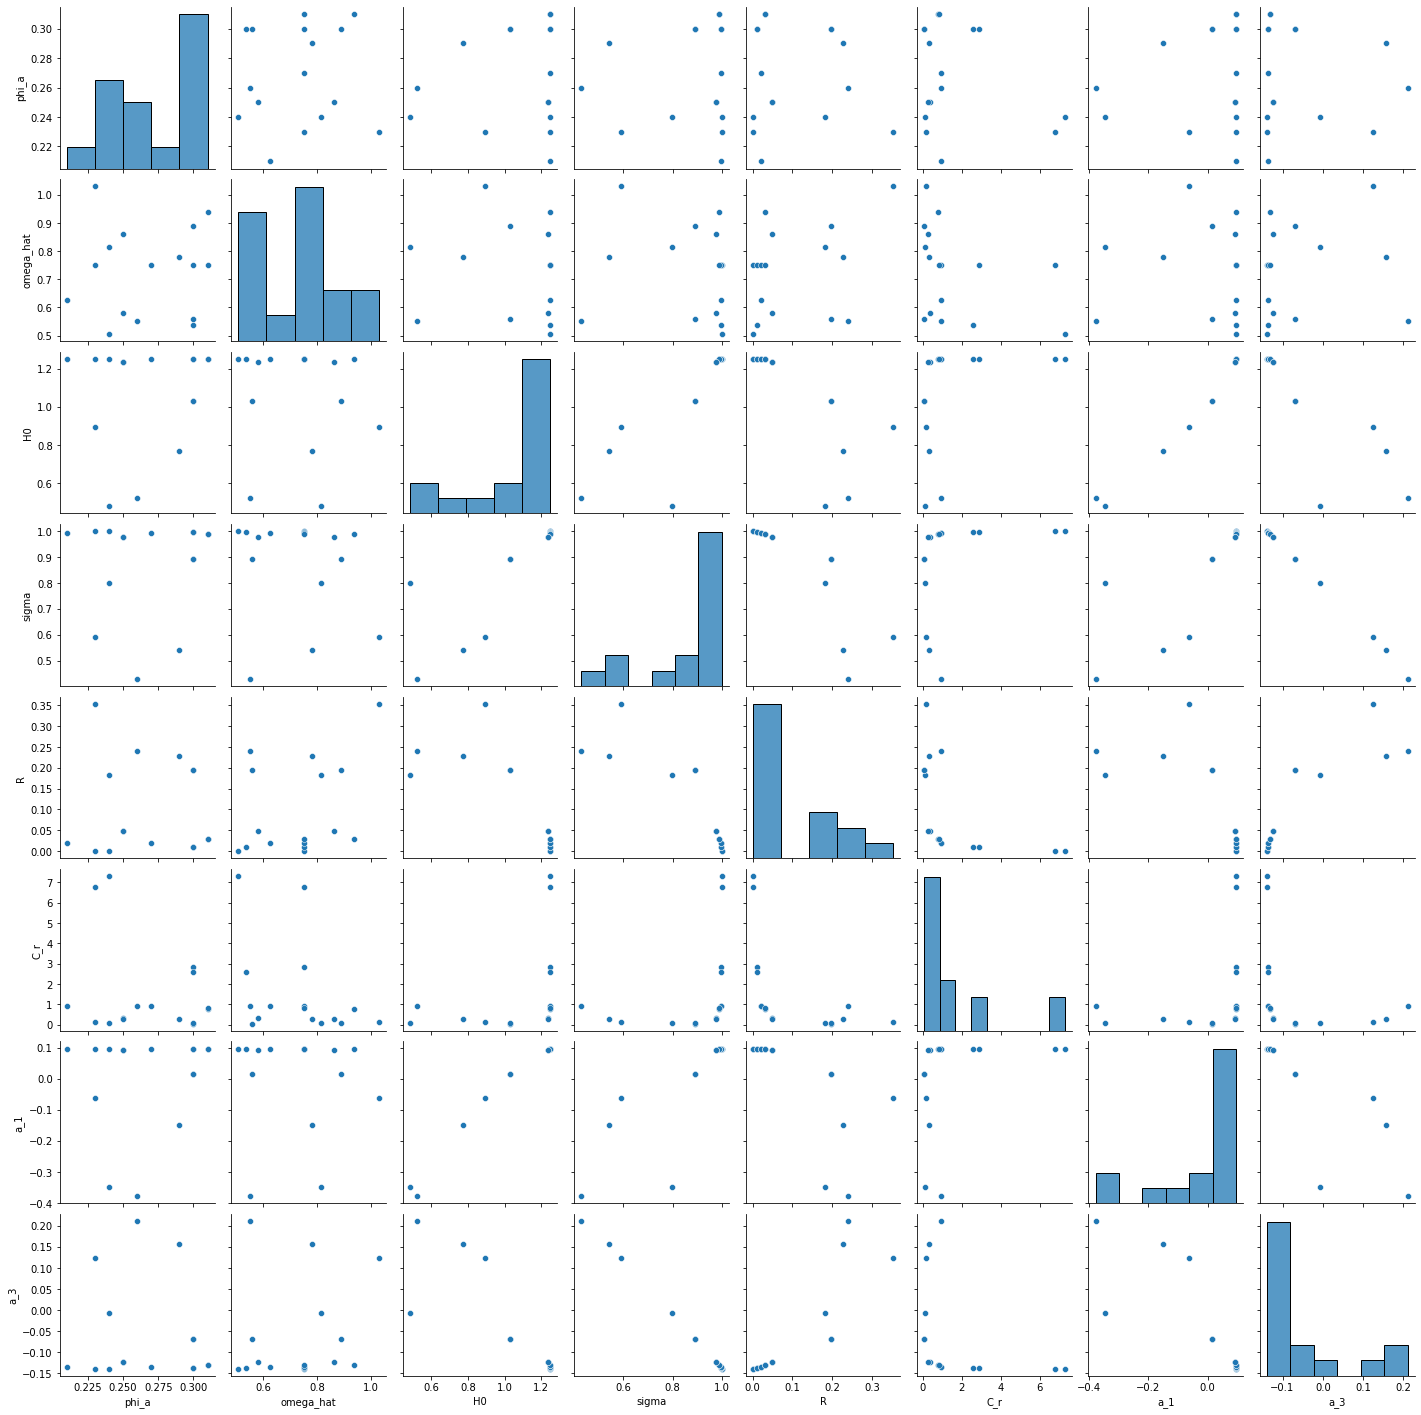

In [15]:
sns.pairplot(data = data)

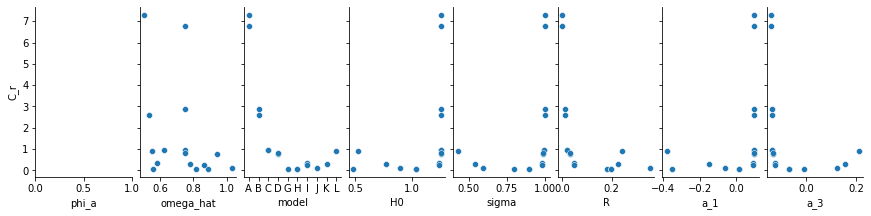

In [16]:
x_vars = list(data.columns)
x_vars.remove('C_r')

grid = sns.pairplot(data = data, x_vars=x_vars, y_vars=['C_r'], height=3)
grid.fig.set_size_inches(12,3)

<AxesSubplot:xlabel='sigma'>

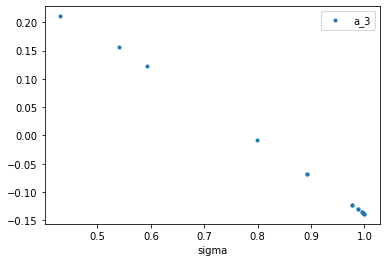

In [17]:
data.plot(x='sigma', y='a_3', style='.')

<AxesSubplot:xlabel='sigma'>

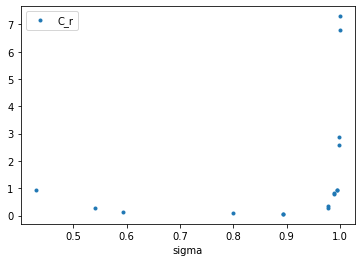

In [18]:
data.plot(x='sigma', y='C_r', style='.')

<AxesSubplot:xlabel='a_3'>

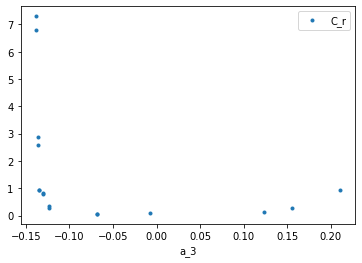

In [19]:
data.plot(x='a_3', y='C_r', style='.')

In [20]:
features = list(data.columns)

In [21]:
data_ = data.select_dtypes(exclude='object')
y = data_.pop('C_r')
X = data_.copy()
X.pop('phi_a')  # Should not depend on this according to Ikeda
X.pop('omega_hat')  # Should not depend on this according to Ikeda

feature_names = X.columns

In [22]:
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree

# create pipeline
rfe = RFE(estimator=DecisionTreeRegressor(), n_features_to_select=3)
descision_tree = DecisionTreeRegressor(max_depth=4, random_state=42)
pipeline = Pipeline(steps=[('s',rfe),('m',descision_tree)])
model = pipeline.fit(X,y)

<AxesSubplot:xlabel='max_depth'>

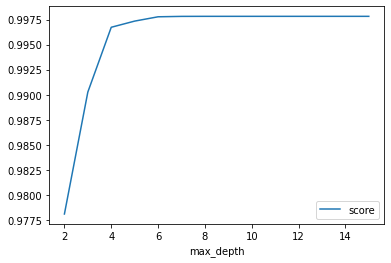

In [23]:


# Fit regression model
descision_tree = DecisionTreeRegressor(max_depth=3)
descision_tree.fit(X, y)

df_trees = pd.DataFrame()
df_trees['max_depth'] = np.arange(1,len(X))
df_trees.set_index('max_depth', inplace=True)

for max_depth, row in df_trees.iterrows():
    descision_tree = DecisionTreeRegressor(max_depth=max_depth,max_features=3, random_state=42)
    descision_tree.fit(X, y)
    df_trees.loc[max_depth,'score'] = descision_tree.score(X, y)
    
fig,ax=plt.subplots()
df_trees.loc[2:].plot(y='score', ax=ax)

<AxesSubplot:xlabel='n_features'>

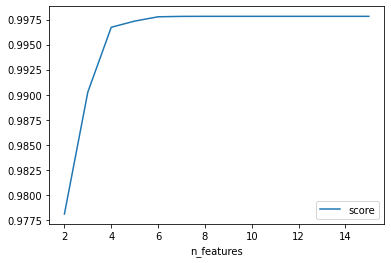

In [24]:
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree

# Fit regression model
descision_tree = DecisionTreeRegressor(max_depth=3)
descision_tree.fit(X, y)

df_trees = pd.DataFrame()
df_trees['n_features'] = np.arange(1,len(X))
df_trees.set_index('n_features', inplace=True)

for n_features, row in df_trees.iterrows():
    
    descision_tree = DecisionTreeRegressor(max_depth=n_features, random_state=42)
    rfe = RFE(estimator=descision_tree, n_features_to_select=2)
    
    pipeline = Pipeline(steps=[('s',rfe),('m',descision_tree)])
    model = pipeline.fit(X,y)
    
    df_trees.loc[n_features,'score'] = model.score(X, y)
    
fig,ax=plt.subplots()
df_trees.loc[2:].plot(y='score', ax=ax)

In [25]:
descision_tree = DecisionTreeRegressor(max_depth=4, random_state=42)
rfe = RFE(estimator=descision_tree, n_features_to_select=3)
rfe.fit(X,y)
good_feature_names = feature_names[rfe.get_support()]
X_good = X[good_feature_names].copy()
descision_tree.fit(X_good,y)
descision_tree.score(X_good,y)

0.9967264383051466

In [26]:
good_feature_names

Index(['sigma', 'a_1', 'a_3'], dtype='object')

In [27]:
y_pred = descision_tree.predict(X_good)
data_pred = df_ikeda_sections.copy()
data_pred['C_r'] = y_pred

<AxesSubplot:xlabel='a_3'>

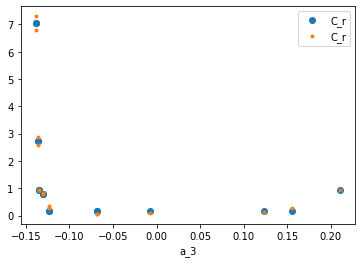

In [28]:
fig,ax=plt.subplots()
data_pred.plot(x='a_3', y='C_r', style='o', ax=ax)
data.plot(x='a_3', y='C_r', style='.', ax=ax)


<a id='tree'></a>

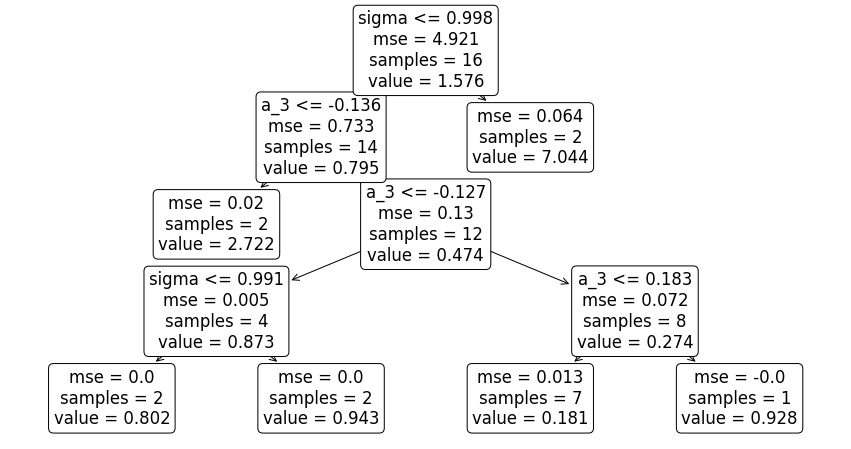

In [29]:
fig,ax = plt.subplots()
fig.set_size_inches(15,8)
tree.plot_tree(descision_tree, ax=ax, feature_names=good_feature_names, rounded=True);

## Go back to $\hat{B_E*}$

In [30]:
solution = sp.solve(equations_ikeda_naked.eq_B_E0_hat, symbols.B_E0_hat)[0]
lambda_B_E0_hat = lambdify(solution)

equations_ikeda_naked.eq_B_E0_hat

Eq(B_E0_HAT, 4*C_r*L_pp*T_s**4*omega_hat*phi_a/(3*pi*Disp*beam**2))

In [31]:
solution = sp.solve(equations_ikeda_naked.eq_B_E_star_hat, symbols.B_E_star_hat)[0]
eq_B_E_star_hat = sp.Eq(symbols.B_E_star_hat, solution)
lambda_B_E_star_hat = lambdify(solution)
eq_B_E_star_hat

Eq(B_E_star_hat, 3*pi*B_E0_HAT/8)

In [32]:
data_pred['B_E0_HAT'] = run(lambda_B_E0_hat, data_pred)

In [33]:
data_pred['B_E_star_hat'] = run(lambda_B_E_star_hat, data_pred)

In [34]:
data_pred.head()

,phi_a,B_star_hat,omega_hat,model,B_W+B_F,B_E_star_hat,L_pp,beam,T_s,Disp,H0,sigma,OG/d,R,B_E0_HAT,C_r,a_1,a_3
0,0.23,0.041169,0.751,A,0.003636,0.038933,0.8,0.28,0.112,0.02509,1.25,1.000,0.0,0.00,0.033048,7.044290,0.095721,-0.138514
1,0.24,0.029803,0.507,A,0.001391,0.027427,0.8,0.28,0.112,0.02509,1.25,1.000,0.0,0.00,0.023280,7.044290,0.095721,-0.138514
2,0.30,0.023966,0.751,B,0.003265,0.019687,0.8,0.28,0.112,0.02501,1.25,0.997,0.0,0.01,0.016711,2.722167,0.095950,-0.136454
3,0.30,0.014438,0.536,B,0.001111,0.014051,0.8,0.28,0.112,0.02501,1.25,0.997,0.0,0.01,0.011927,2.722167,0.095950,-0.136454
4,0.27,0.008265,0.751,C,0.002115,0.006155,0.8,0.28,0.112,0.02495,1.25,0.995,0.0,0.02,0.005224,0.943338,0.096102,-0.135084


In [35]:
len(df_ikeda_sections.groupby(by='model'))

10

In [36]:
def plot(data_pred):
    
    data_pred_groups = data_pred.groupby(by=['model','omega_hat'])
    
    y_key = 'B_E_star_hat'
    y_max = np.max([df_ikeda_sections[y_key].max(), data_pred[y_key].max()])
    
    model_groups = df_ikeda_sections.groupby(by='model')
    fig,axes=plt.subplots(ncols=3, nrows=4)
    fig.set_size_inches(10,15)
    axes=axes.flatten()[0:len(model_groups)]
    
    for (model_name, ikeda_data),ax in zip(model_groups,axes):
        
        ax.set_title(model_name)
        
        for w_hat, df_ in ikeda_data.groupby(by='omega_hat'):
            
            label = '$\hat{\omega}=%0.3f$' % w_hat
            x = df_['phi_a']
            y = df_[y_key]
            lines = ax.plot([0,x], [0,y], 'o', label=label)
            line = lines[-1]
            color = line.get_color()
            
            df_pred = data_pred_groups.get_group((model_name,w_hat))
            
            label = 'prediction'
            x = df_pred['phi_a']
            y = df_pred[y_key]
            lines = ax.plot([0,x], [0,y], '--', color=color, label=label)
        
        ax.set_ylim((0,y_max))
        ax.legend()


c:\dev\prediction-of-roll-damping-using-fully-nonlinear-potential-flow-and-ikedas-method\venv\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


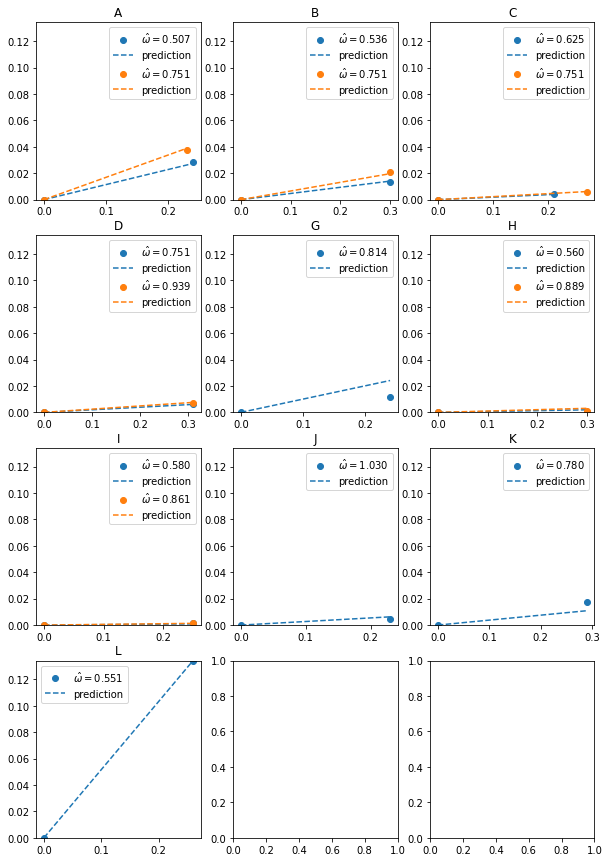

In [37]:
plot(data_pred)

## Regular Ikeda

In [38]:
data2 = df_ikeda_sections.copy()

c:\dev\prediction-of-roll-damping-using-fully-nonlinear-potential-flow-and-ikedas-method\venv\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


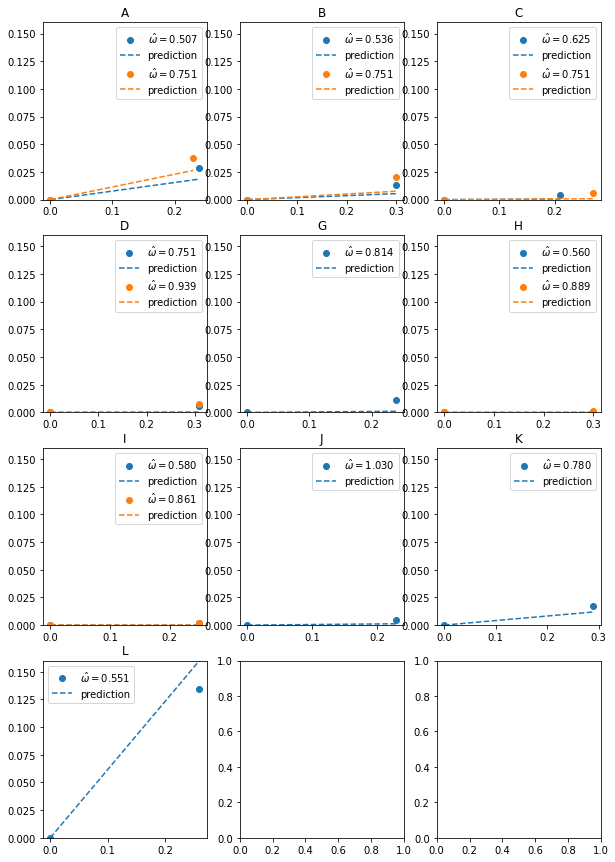

In [39]:
ra = 1000
data2['C_r'] = ikeda_naked.calculate_C_r(bwl=data2.beam,
                          a_1=data2.a_1, a_3=data2.a_3, sigma=data2.sigma, 
                                              H0=data2.H0, d=data2['T_s'], OG=0, 
                          R=data2.R, ra=ra)

data2['B_E0_HAT'] = run(lambda_B_E0_hat, data2)
data2['B_E_star_hat'] = run(lambda_B_E_star_hat, data2)
plot(data2)

## KVLCC2

In [40]:
df_kvlcc2 = pd.read_csv('../../data/interim/kvlcc_areas.csv', sep=';', index_col=0)
#scale_factor = 68.0
#df_kvlcc2/=scale_factor
#df_kvlcc2['area']/=scale_factor
df_kvlcc2.head()

,area,x,t,b,r_b
no,,,,,
0,13.826612,-5.495000,2.00,11.638577,6.636080
1,123.851306,10.159932,18.25,27.893522,42.367175
2,428.211409,28.051284,20.80,41.824284,45.369454
3,683.709165,43.706216,20.80,50.282514,41.080696
4,917.895066,61.597568,20.80,56.159232,34.146143


In [41]:
df_kvlcc2.rename(columns={
    'b':'beam',
    't':'T',
    'r_b':'R',
}, inplace=True)
df_kvlcc2['sigma']=df_kvlcc2.area/(df_kvlcc2.beam*df_kvlcc2['T'])
df_kvlcc2['OG/d']=0  # For now...

In [42]:
df_ = df_kvlcc2.copy()
df_.rename(columns={
    'beam':'B',
    'T':'d',
}, inplace=True)

a, a_1, a_3, sigma_s, H = calculate_lewis(df_)
df_kvlcc2['a_1'] = a_1
df_kvlcc2['a_3'] = a_3
df_kvlcc2['H0'] = H

In [43]:
df_kvlcc2_ = df_kvlcc2.copy()
OG = df_kvlcc2_['OG/d']*df_kvlcc2_['T']

df_kvlcc2_['C_r'] = ikeda_naked.calculate_C_r(bwl=df_kvlcc2_.beam,
                          a_1=df_kvlcc2_.a_1, a_3=df_kvlcc2_.a_3, sigma=df_kvlcc2_.sigma, 
                                              H0=df_kvlcc2_.H0, d=df_kvlcc2_['T'], OG=OG, 
                          R=df_kvlcc2_.R, ra=ra)

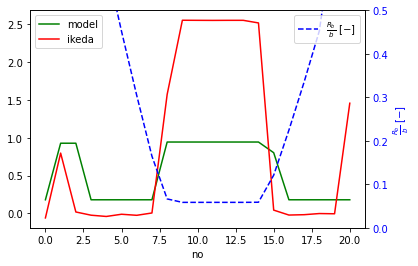

In [44]:
#mask = df_kvlcc2['sigma'] > 0.996
#df_kvlcc2['sigma'] = 0.996
df_kvlcc2['C_r'] = descision_tree.predict(X=df_kvlcc2[good_feature_names])

fig,ax=plt.subplots()
df_kvlcc2['R/b'] = df_kvlcc2['R']/df_kvlcc2['beam']
df_kvlcc2.plot(y='C_r', label='model', color='g', ax=ax)
df_kvlcc2_.plot(y='C_r', label='ikeda', color='r', ax=ax)
ax.legend(loc='upper left')

ax_R_b = ax.twinx()
ax_R_b.tick_params(axis='y', labelcolor='blue')
df_kvlcc2.plot(y='R/b', ax=ax_R_b, style='--', label=r'$\frac{R_b}{b}$ $[-]$', color='blue')
ax_R_b.set_ylim(0,0.5)
ax_R_b.set_ylabel(r'$\frac{R_b}{b}$ $[-]$', color='blue')
ax_R_b.legend(loc='upper right')

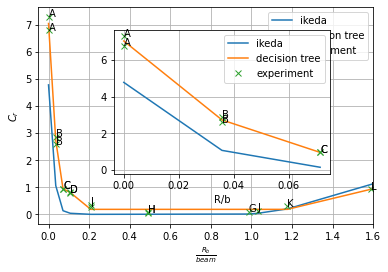

In [45]:
fig,ax=plt.subplots()
key = 'R/b'
data2[key] = data2['R'] / data2['beam']
data[key] = data2[key]
data_pred[key] = data2[key]

def plot(ax, data, data2, data_pred):
    data2.sort_values(by=key).plot(x=key, y='C_r', style='-', label='ikeda', ax=ax)
    data_pred.sort_values(by=key).plot(x=key, y='C_r', style='-', label='decision tree', ax=ax)
    data.sort_values(by=key).plot(x=key, y='C_r', style='x', label='experiment', ax=ax)
    
    ax.grid(True)

    for _,row in data.iterrows():
        ax.annotate(row['model'], xy=(row[key],row['C_r']))

    
plot(ax=ax, data=data, data2=data2, data_pred=data_pred)

ax.legend() 
ax.set_title('')
ax.set_xlim(-0.05,1.6)
ax.set_xlabel(r'$\frac{R_b}{beam}$')
ax.set_ylabel(r'$C_r$')


ax_zoom = fig.add_axes([0.3, 0.3, .5, .5], zorder=1)

R_b_max=0.1
data_zoom = data.loc[data['R/b']<R_b_max]
data2_zoom = data2.loc[data2['R/b']<R_b_max]
data_pred_zoom = data_pred.loc[data_pred['R/b']<R_b_max]
plot(ax=ax_zoom, data=data_zoom, data2=data2_zoom, data_pred=data_pred_zoom)


In [46]:
good_feature_names

Index(['sigma', 'a_1', 'a_3'], dtype='object')

In [47]:
joblib.dump(descision_tree, '../../models/C_r_tree.pkl')

['../../models/C_r_tree.pkl']